## COMPOSITE
COMPOSITE (COMpound POiSson multIplet deTEction model) works for RNA, ADT, and ATAC modality.
### Setup and Load Data
Data files are in the 'filtered_feature_bc_matrix' folder along with other output from CellRanger. 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os

# For COMPOSITE
import sccomposite # pip install torch if necessary
from sccomposite import ATAC_modality # There are other modalities, but irrelevant for this project

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# data files are in the filtered matrix folder from CellRanger which has been renamed to the sample name
sample_name = r'sc85_3g' #r'sc70_1' #r'sc72_1'
data_path = r"../raw_data/"
data_files_path = data_path + sample_name + r""

results_path = 'results/'
results_file = results_path + sample_name + 'COMPOSITE-db.h5ad'  # the file that will store the analysis results
metrics_file = results_path + sample_name + 'COMPOSITE_db_metrics.csv'  # the file that will store the metrics
# make results folder if it doesn't exist
if not os.path.exists(results_path):
    os.makedirs(results_path, exist_ok=False)

C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


#### Load data

Read in count data into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.  
The matrix.mtx file contains a sparse matrix of the counts.  
Barcodes file contains the sample names in the format: AAACCCAAGACCATAA-1  
Features file contains the gene id in the format: ENSMUSG00000051951, Xkr4, Gene Expression

The number of counts per cell will be relatively low since only UMIs are counted by Cellranger

In [2]:
adata = sc.read_10x_mtx(
    data_files_path,              # the directory with the `.mtx` file
    var_names='gene_symbols',     # use gene symbols for the variable names (variables-axis index)
    cache=True)                   # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

# make the obs names unique by adding the sample name
adata.obs_names = [g.split("-")[0] + '_' + sample_name for g in adata.obs_names]
print(adata.obs_names[0:2])
print()
print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

... reading from cache file cache\..-raw_data-sc85_3g-matrix.h5ad
Data matrix is sparse: True

Index(['AAACAGCCAACATAAG_sc85_3g', 'AAACAGCCAATGAAGC_sc85_3g'], dtype='object')

Number of cells = 13,572
Number of genes = 36,530
Number of counts = 18,226,496
Mean counts per cell = 1,343


AnnData object with n_obs × n_vars = 13572 × 36530
    var: 'gene_ids', 'feature_types'

In [3]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_19412\1815972615.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_19412\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    36,530
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_19412\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    18,226,496
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_3g,13572.0,"36,530","18,226,496","1,343"


### Detect doublets

In [4]:
# Didn't necessarily say to remove "empty" genes
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 11005 genes that are detected in less than 1 cells


In [5]:
data_mat = adata.X                # transform data matrix

In [6]:
import scipy.io as sio
mtx_data = sio.mmread(data_files_path + "/ATAC.mtx")
print("Matrix shape:", mtx_data.shape)
print("Sparsity:", 1.0 - (mtx_data.nnz / (mtx_data.shape[0] * mtx_data.shape[1])))

Matrix shape: (36530, 13572)
Sparsity: 0.9743946309324789


In [7]:
print(os.path.exists(data_files_path + "/atac.mtx"))
multiplet_classification, consistency = ATAC_modality.composite_atac(data_files_path + "/atac.mtx")
# was receiving errors around the float128, changed this to float64 in the source code

True
Cuda is not available; Fitting the COMPOSITE model on ATAC modality
The ATAC goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC modality goodness-of-fit score is: 2.367503363889849 
<3: poor fit 
3~5: moderate fit 
>5: good fit


In [8]:
multiplets = [1.0 if x == 1 else 0 for x in multiplet_classification]
adata.obs["COMPOSITE_class"] = multiplet_classification
adata.obs["multiplets"] = multiplets

In [9]:
multiplet_percentage = sum(multiplets)/adata.n_obs*100
print('multiplet percentage = %4.1f' %(multiplet_percentage))
df_metrics['Multiplet removal:'] = ' '
df_metrics['Multiplet percentage'] =  multiplet_percentage

multiplet percentage =  4.1


In [10]:
num_before = adata.n_obs
singlets = adata.obs["COMPOSITE_class"] == 0
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before multiplet removal =', num_before)
print('Number of cells after multiplet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After multiplet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before multiplet removal = 13572
Number of cells after multiplet removal = 13009
Number of cells removed = 563
Percentage of cells removed =  4.1
Number of counts = 18,226,496
Mean counts per cell = 1,173


In [11]:
adata[singlets].write(results_file)
# print(adata)

C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\_core\anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [12]:
df_metrics.T.to_csv(metrics_file)

### UMAP
Visualize the data before and after doublet removal.

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)


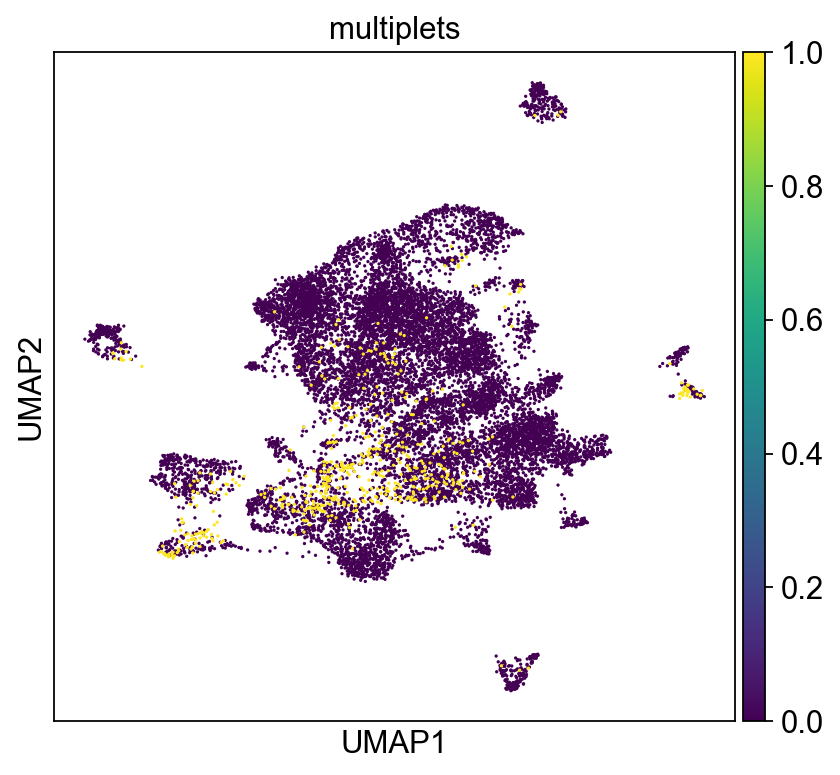

In [16]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color=['multiplets'])

### Exporting Doublets to a `.txt` file
Printing out doublet subsets for future comparisons

In [17]:
print(adata.obs[adata.obs['COMPOSITE_class'] == 1])
adata_dbl = adata[adata.obs['COMPOSITE_class'] == 1].copy()

                          COMPOSITE_class  multiplets
AAACAGCCAATTAAGG_sc85_3g                1         1.0
AAACCGGCATGGCCCA_sc85_3g                1         1.0
AAACGCGCAAGGCCAA_sc85_3g                1         1.0
AAAGCCCGTACAATGT_sc85_3g                1         1.0
AAAGCCGCACACCAAC_sc85_3g                1         1.0
...                                   ...         ...
TTTCTTGCAACTGGGA_sc85_3g                1         1.0
TTTCTTGCACAACCTA_sc85_3g                1         1.0
TTTGAGTCAACACTTG_sc85_3g                1         1.0
TTTGAGTCAACCCTCC_sc85_3g                1         1.0
TTTGTCTAGAACCTGT_sc85_3g                1         1.0

[563 rows x 2 columns]


In [18]:
print(adata_dbl.obs_names)

Index(['AAACAGCCAATTAAGG_sc85_3g', 'AAACCGGCATGGCCCA_sc85_3g',
       'AAACGCGCAAGGCCAA_sc85_3g', 'AAAGCCCGTACAATGT_sc85_3g',
       'AAAGCCGCACACCAAC_sc85_3g', 'AAAGCGGGTTACGCAA_sc85_3g',
       'AAAGGAGCATTGTGAT_sc85_3g', 'AAAGGCTCAGCCTGCA_sc85_3g',
       'AAATGCCTCCCGCATT_sc85_3g', 'AAATGCCTCGCTAAGT_sc85_3g',
       ...
       'TTGTTCCCAGGTATTT_sc85_3g', 'TTGTTGCGTTCAAGCA_sc85_3g',
       'TTTACGAAGACTATTG_sc85_3g', 'TTTCGTCCACCTATAG_sc85_3g',
       'TTTCGTCCATCGCTCC_sc85_3g', 'TTTCTTGCAACTGGGA_sc85_3g',
       'TTTCTTGCACAACCTA_sc85_3g', 'TTTGAGTCAACACTTG_sc85_3g',
       'TTTGAGTCAACCCTCC_sc85_3g', 'TTTGTCTAGAACCTGT_sc85_3g'],
      dtype='object', length=563)


In [19]:
with open("../IDs/COMPOSITE_sc85_3g_atac_ids.txt", "w") as txt_file:
    for cell in adata_dbl.obs_names:
        txt_file.write(cell + "\n")